# Estimation of linear filter using analytical solution
## Comparison of the solution using the Normal Equation, PC regression and Ridge.
### In this exercise you will estimate a visual spatio-temporal receptive field from a model neuron driven by a natural movie. 

In [1]:
# Load up the depencies

import numpy as np
import mne
import os.path as op
import os
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy.signal import convolve
plt.ion()

In [2]:
# Set up the paths for the data
path_base = os.path.join('..')
path_data = op.join(path_base, 'data')
path_stims = op.join(path_data, 'all_stims')

## Load a 20000 (time) x 10 x 10  natural movie and preprocess

In [3]:
# Load up the movie.  Notice the size of the movie.
data = loadmat(op.join(path_data, 'mov.mat'))
movie_all = data['mov']
movie_all = movie_all.transpose([2, 0, 1])
print(movie_all.shape)

(20000, 10, 10)


In [4]:
# Subtract the mean to obtain a zeroed stimulus
mean_stim = movie_all.mean()
movie_all = movie_all - mean_stim
fitPoints = 15000

# Part of the movie for fitting
movie = movie_all[0:fitPoints]

# Part of the movie for testing
movie_test = movie_all[fitPoints:]

## Exercise 1  
### Using subplots plot the first 10 images.
### Using these pictures comment on the temporal and spatial correlations.
### Plot them using a grey map and with the correct aspect ratio. Also remove the two axes.

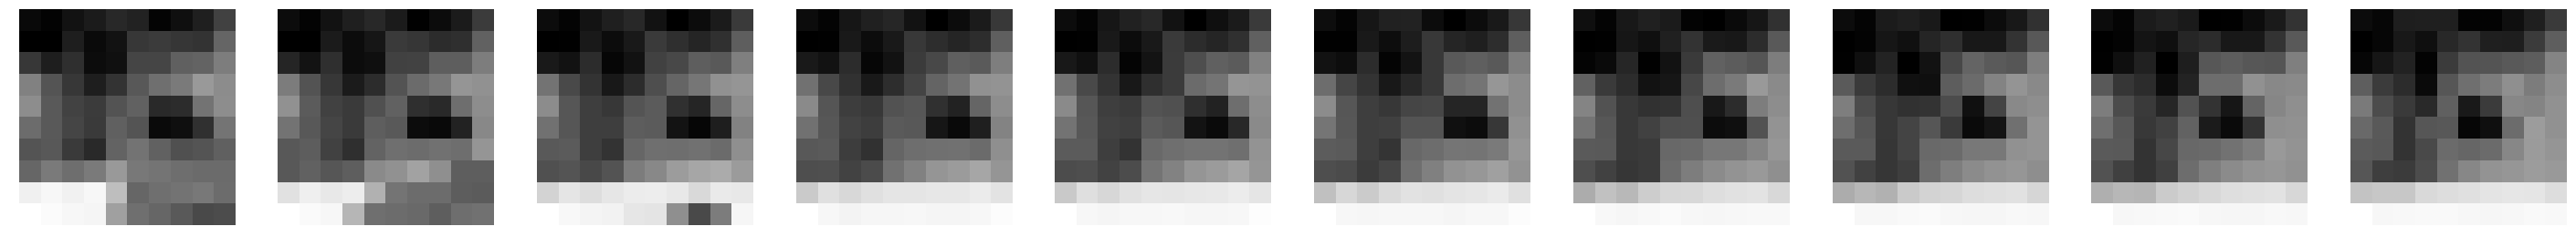

In [5]:
# YOUR CODE HERE
raise NotImplementedError()

### Now plot images 10, 100, 1000, 10000.  

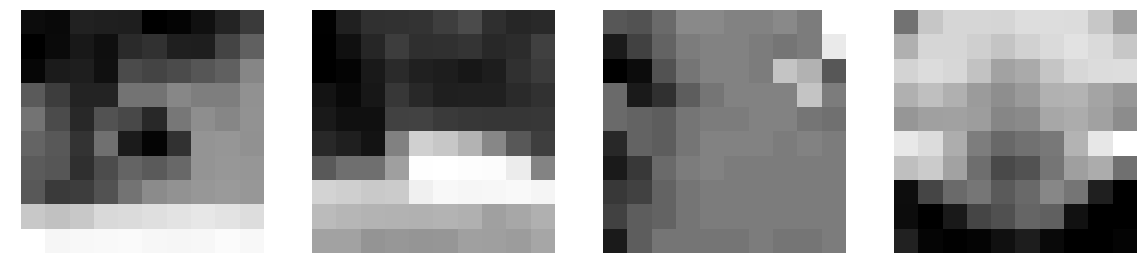

In [6]:
# YOUR CODE HERE
raise NotImplementedError()

Comment on spatial / temporal correlations here:



## Model Neuron.
### We are going to create responses for model simple cell in V1 with a STRF that is a 2D Gabor filter.


In [7]:
# Generating a 2d Gabor 

# Some useful functions
from skimage.filters import gabor, gabor_kernel
from scipy import ndimage as ndi

In [8]:
# We are only going to use on gabor but here is code that you can use
# to generate a filter bank. We are calling the filters kernels.

kernels = []
theta = 0       # Orientation of the Gabor in degrees
theta = (theta/180.0) * np.pi # In radiants.
sigma = 1       # Bandwidth
frequency = 0.4  # Spatial frequency in pixels.
offset = np.pi/8

kernel = np.real(gabor_kernel(frequency, theta=theta, bandwidth=sigma, offset = offset))
kernel = kernel[:10, :10]
kernels.append(kernel)

kernel = np.imag(gabor_kernel(frequency, theta=theta, bandwidth=sigma, offset = offset))
kernel = kernel[:10, :10]
kernels.append(kernel)



## Exercise 2  
### We have generated two Gabors with sine and cosine harmonic. Plot them using grey scale.  


(10, 10)
(10, 10)


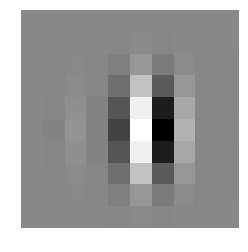

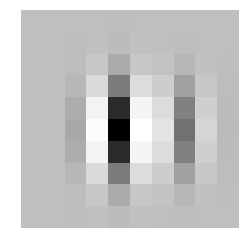

In [9]:
# YOUR CODE HERE
raise NotImplementedError()

## Generation of the model neuron response.
### The model response is obtained by convolving the Gabor filter with the stimulus and adding Gaussian noise to get a response with an SNR of 0.5

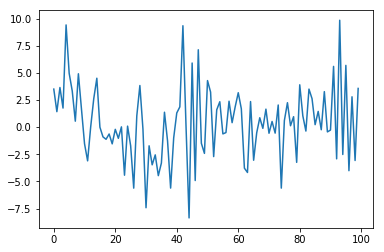

In [10]:
# Convolve the movie with the filter
kernel = kernels[0]
movie_vec = movie.reshape([movie.shape[0], -1])
resp = np.dot(movie_vec, kernel.ravel())     # np.dot performs matrix multiplication

# Add noise to the response
resp_pow = np.var(resp)
SNR = 0.5
resp = resp + np.sqrt(resp_pow / SNR) * np.random.randn(len(resp), *resp.shape[1:])

# Plot the firt 100 time points of the response
fig, axs = plt.subplots()
axs.plot(resp[0:100])

# Recovering the filter.

## Exercise 3.
### Find the cross-correlation between the stimulus and the response (Note: In this case there is no time component).  Plot it and compare it to the original filter.  This is also the spike-triggered average or STA.
### Find the stimulus auto-correlation and visualize it. Explain what you see.

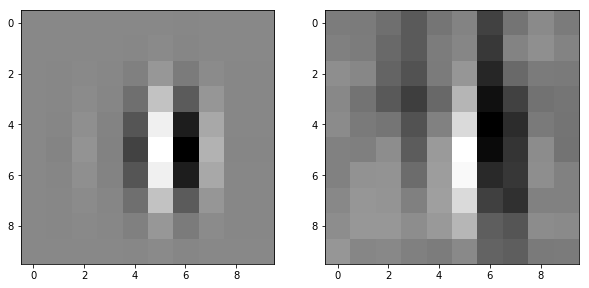

In [11]:
# YOUR CODE HERE
raise NotImplementedError()

[Text(0.5,1,'Auto Correlation')]

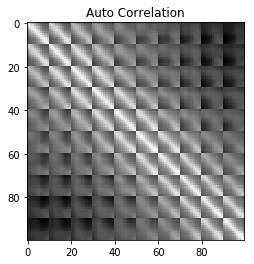

In [14]:
# YOUR CODE HERE
raise NotImplementedError()

## Exercise 4. 
### Estimate the filter using the normal equation: Cross-correlation/Auto-correlation
### Hints: np.dot() is matrix multiplication and np.linalg.inv() can be used to obtain the inverse of the stimulus Auto-correlation.
### Note in Python 3, you can use @ for np.dot()


In [15]:
mean_auto_corr

array([[2135.59280633, 1918.83730574, 1608.65930964, ...,  766.18297057,
         754.29643632,  717.01791585],
       [1918.83730574, 2172.46413849, 1928.43647572, ...,  783.57506999,
         786.7664024 ,  761.5331486 ],
       [1608.65930964, 1928.43647572, 2146.05441296, ...,  806.60960722,
         799.77727296,  772.31501917],
       ...,
       [ 766.18297057,  783.57506999,  806.60960722, ..., 2320.38880148,
        2077.11153389, 1812.6082801 ],
       [ 754.29643632,  786.7664024 ,  799.77727296, ..., 2077.11153389,
        2302.33233297, 2065.05334584],
       [ 717.01791585,  761.5331486 ,  772.31501917, ..., 1812.6082801 ,
        2065.05334584, 2273.24655872]])

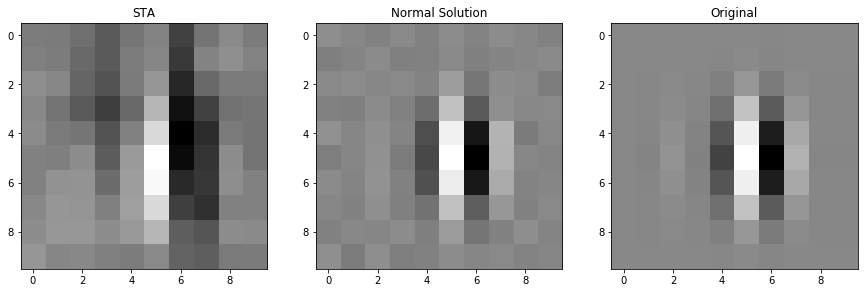

In [16]:
# YOUR CODE HERE
raise NotImplementedError()

## Exercise 5.  Obtain the Filter using PCA regression. Try the projection in 10, 20, 50, 100 eigen dimensions. 
### Hints: You can perform an svd on a auto-correlation matrix to get the eigenvectors: np.linalg.svd()
### Alternatively you can use the eigenvalue decomposition: np.linalg.eig()

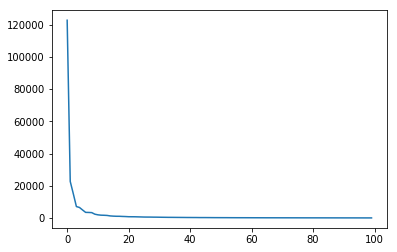

In [17]:
# YOUR CODE HERE
raise NotImplementedError()


In [18]:
# Obtain filters by calculating the filter in subspaces of 10, 20, 50 and 100.

# YOUR CODE HERE
raise NotImplementedError()


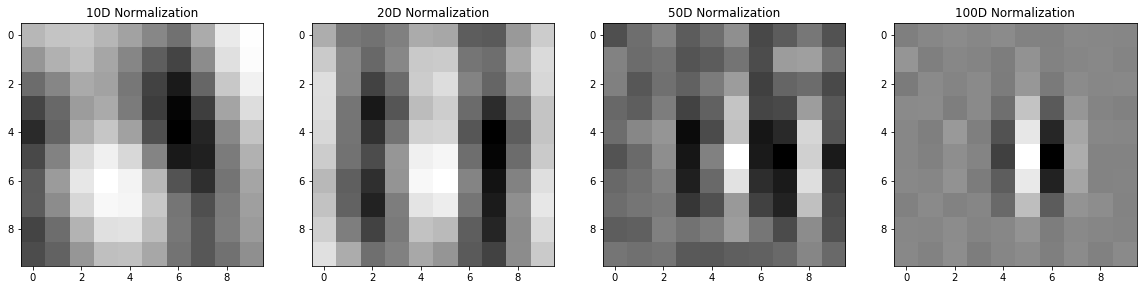

In [17]:
# Plot the results

# YOUR CODE HERE
raise NotImplementedError()


In [19]:
# Solution using eig

# YOUR CODE HERE
raise NotImplementedError()


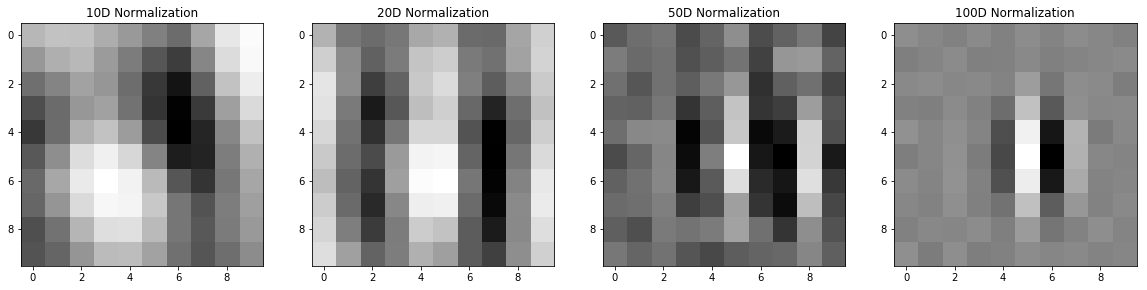

In [20]:
# Now plot the results

# YOUR CODE HERE
raise NotImplementedError()


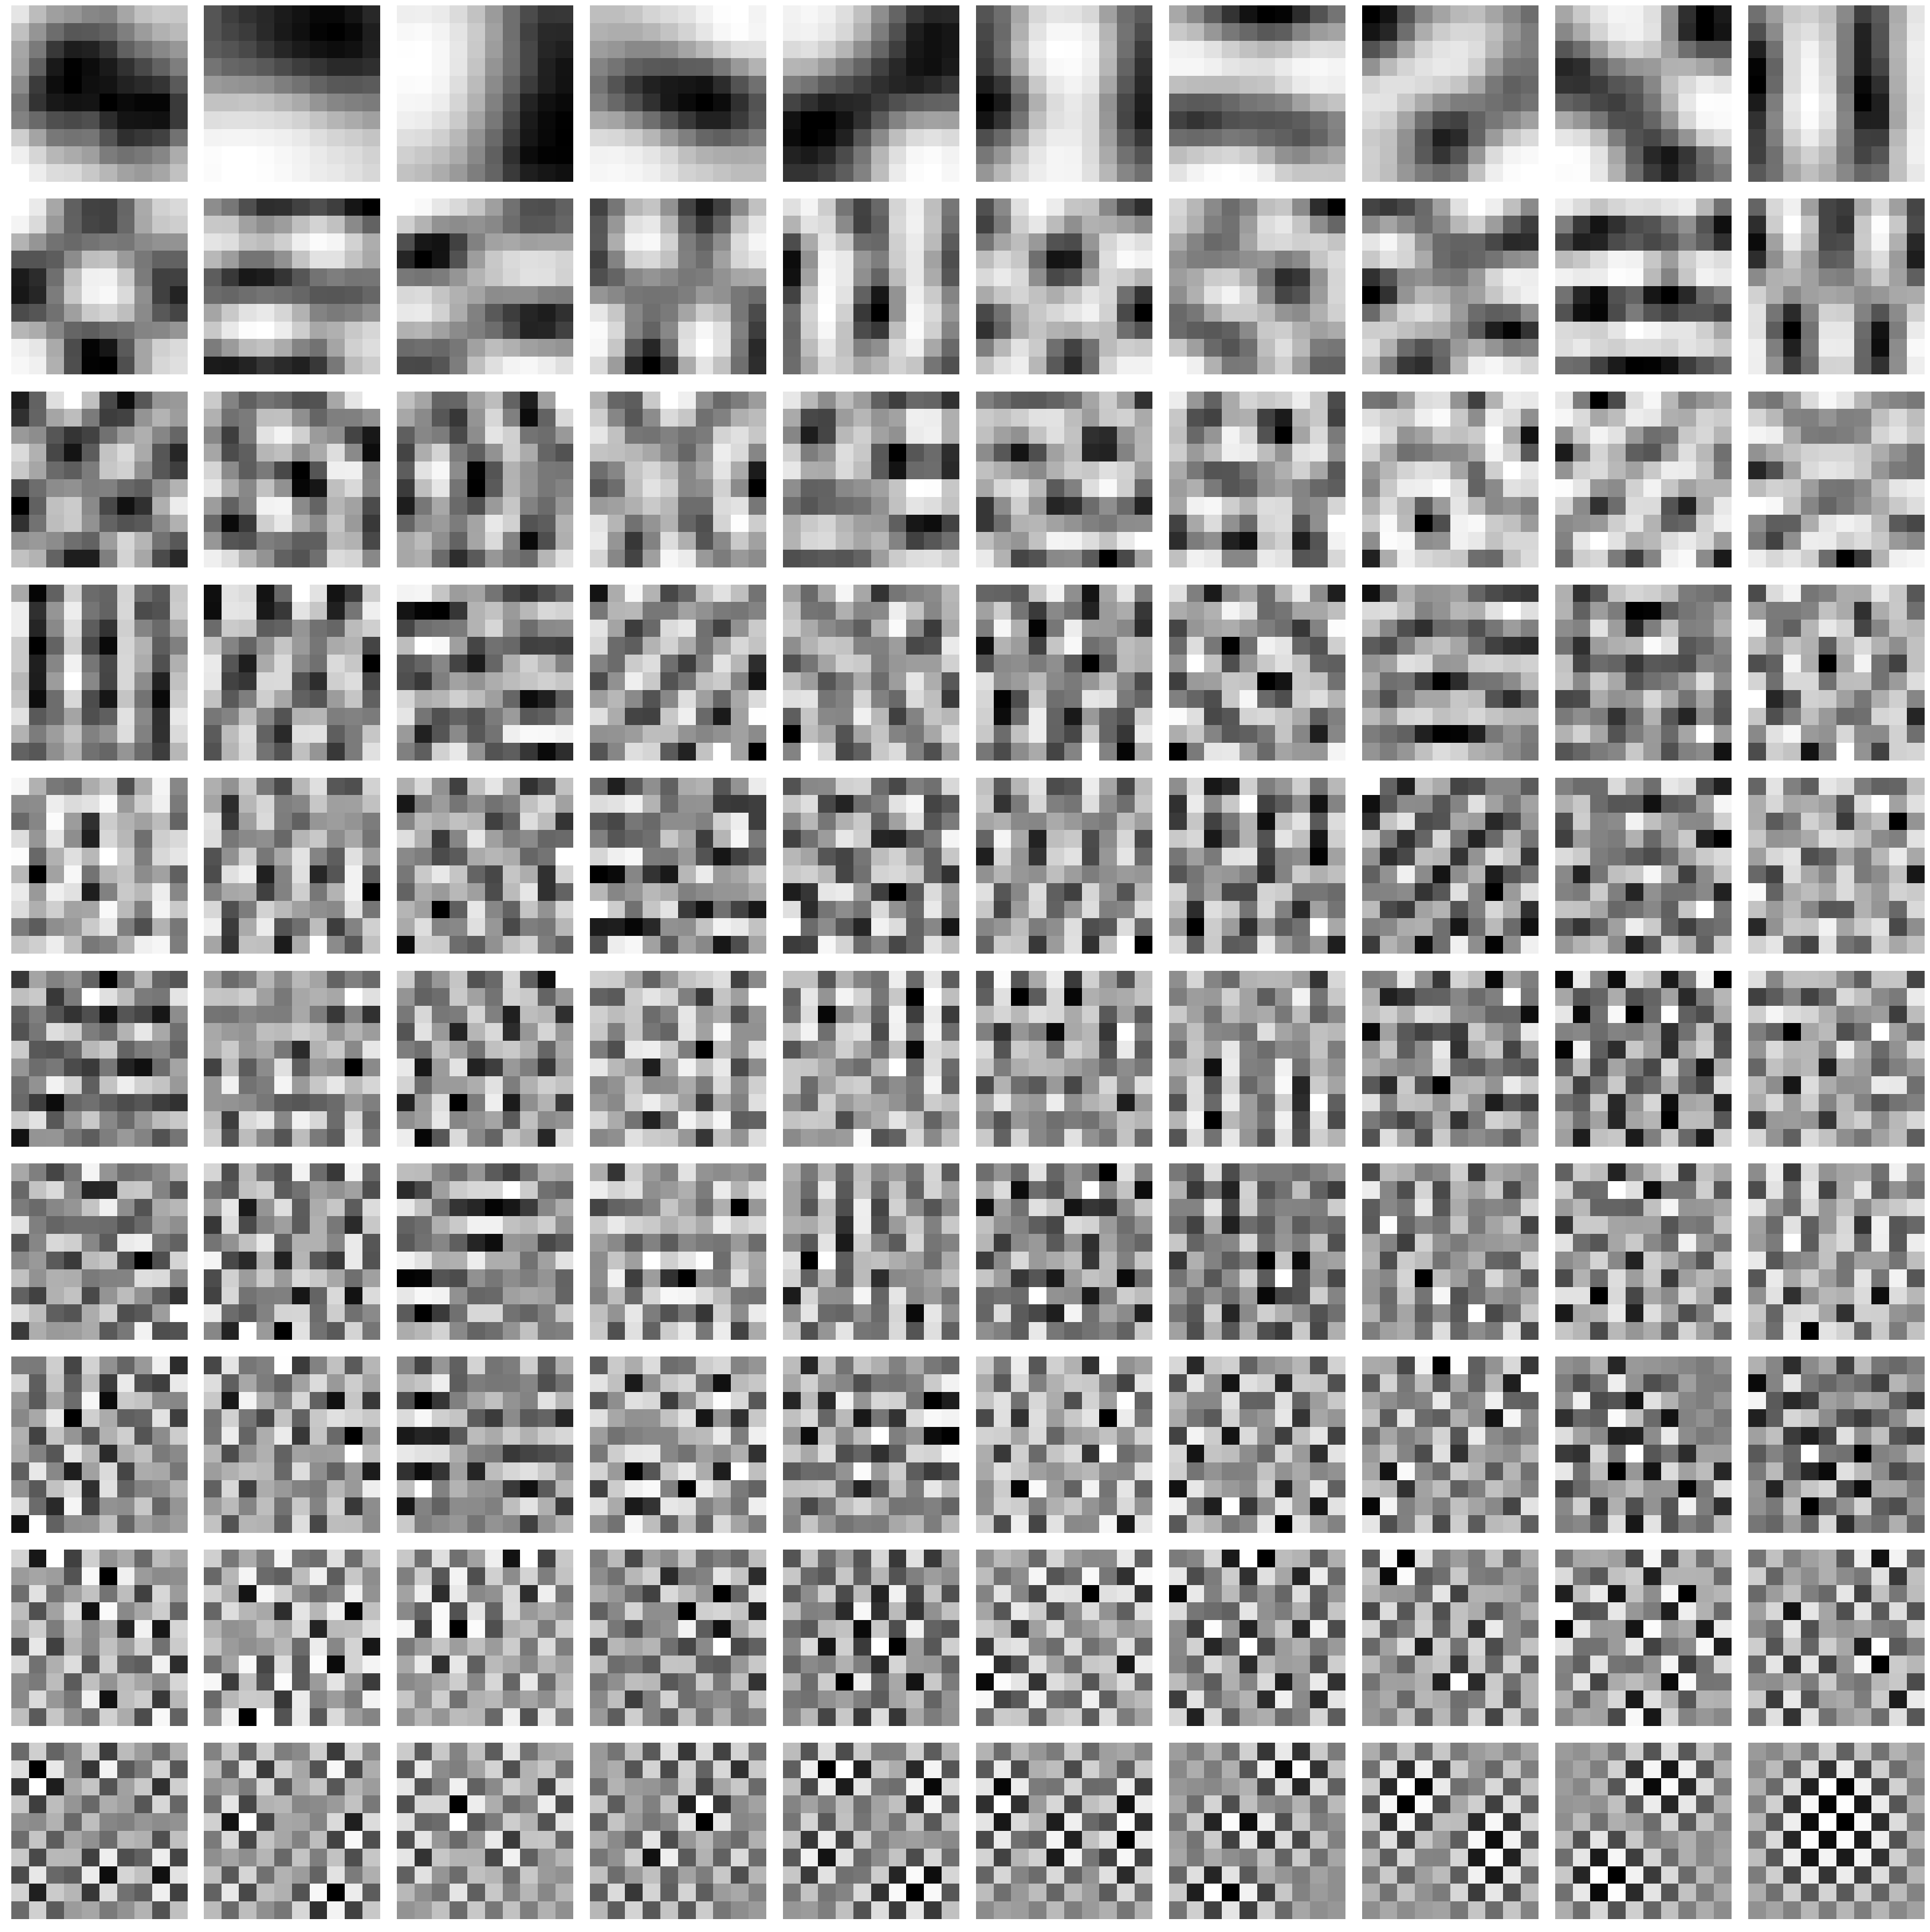

In [21]:
# Now plot all 100 eigenvectors of our natual movie.

# YOUR CODE HERE
raise NotImplementedError()


## Excercise 6 (Optional).  Perform the same calculation in the Fourier Domain.  
### In the Fourier domain the matrix division becomes a scalar division between two complex numbers. 
### This is a form of regularization as it assumes stationary second order statistics.

### Instructions: First calculate the Fourier Transform of the cross-correlation and auto correlation function. You should do this calculation in the 10x10 space and for the auto correlation, you can either reshape and average the 100x100 auto-correlation function (averaring the block diagonals) or recalculate the power spectrum of the image. You can then divide the cross-correlation by the auto-correlation in the Fourier domain. Finally take the inverse FFT to get back the filter. Did it give exactly the same result?

In [22]:
# Calculate the auto correlation in the Fourier domain.

# YOUR CODE HERE
raise NotImplementedError()


[Text(0.5,1,'Power spectrum of stimulus')]

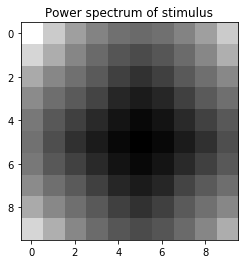

In [23]:
# Calculate and plot stimulus power

# YOUR CODE HERE
raise NotImplementedError()


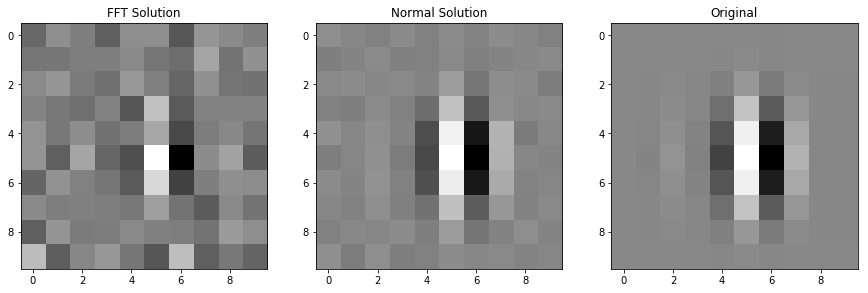

In [24]:
# Calculate the FFT of the cross-correlation, and derive the linear filter from this, then plot the results

# YOUR CODE HERE
raise NotImplementedError()


## Exercise 7. Calculate the Ridge Solution.
### Hint. Reuse the PCA regression code using values for lamba (the ridge parameter) of 0, 100, 1000 and 10000.

In [25]:
# YOUR CODE HERE
raise NotImplementedError()


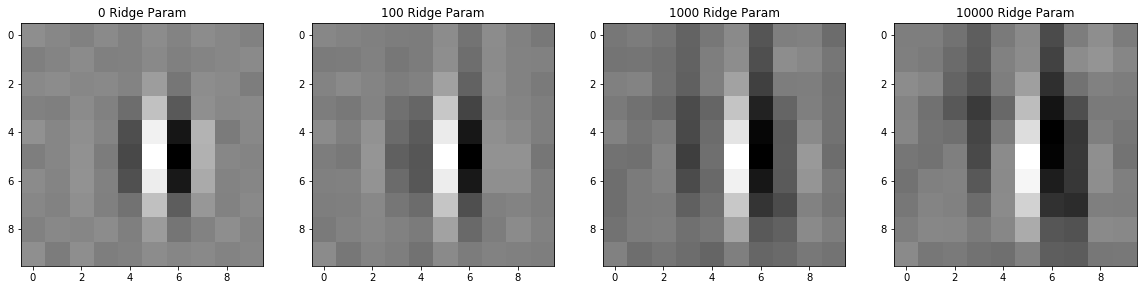

In [26]:
# Plot the different ridge solutions

# YOUR CODE HERE
raise NotImplementedError()


## Play around with other values of SNR and smaller amounts of data.